# Chapter 09 — Natural Language Processing with TensorFlow: Sentiment Analysis

This chapter is my first full end-to-end NLP workflow in the book. The data source is a real-world Amazon review dataset (Video Games category), which is a good example of what practical text data looks like:
- large scale (hundreds of thousands of reviews),
- noisy and inconsistent writing,
- imbalanced ratings,
- and extra metadata that can be used for filtering (for example, `verified` purchases).

The objective is **sentiment analysis**: given a review text, predict whether the sentiment is positive or negative.

I follow the chapter’s structure:
1) download + inspect the dataset,
2) filter and label it in a way that matches the problem definition,
3) create train/validation/test splits carefully (balanced validation/test sets),
4) explore vocabulary size and sequence length (to set model hyperparameters),
5) build an end-to-end TensorFlow pipeline (raw text → vectorization → model),
6) train and evaluate a sentiment classifier (LSTM-based),
7) inspect model behavior by looking at predictions and mistakes.


## 1) Summary

### 1.1 What makes text different from images
Text is not naturally represented as a fixed-size tensor. A review is a variable-length sequence of words, and different reviews can have completely different lengths and vocabulary. This means the “data preparation” stage in NLP is not optional; it is a core part of the modeling pipeline.

In this chapter, I treat sentiment analysis as a classification task. The model receives a review (sequence of tokens) and predicts one of two classes:
- **positive** sentiment
- **negative** sentiment

### 1.2 Dataset and labeling choice
The dataset used is the Amazon review dataset (Video Games, small category file). Each record is a JSON dictionary with fields such as:
- `reviewText` (main text),
- `overall` (star rating: 1 to 5),
- `verified` (whether the reviewer is a verified buyer).

To define sentiment labels, the chapter makes a practical modeling decision:
- **4 or 5 stars → positive (label = 1)**
- **1, 2, or 3 stars → negative (label = 0)**

This reduces complexity compared with five-class prediction, and it turns the problem into a binary classification task that is easier to optimize and evaluate.

### 1.3 Why the split strategy matters
A naive random split would produce validation/test sets that inherit the same class imbalance as the full dataset. With strong imbalance, standard accuracy can be misleading (a model can do “well” by mostly predicting the majority class).

The chapter’s approach is more careful:
- build **balanced validation and test sets** (equal positives and negatives),
- assign all remaining data points to the training set.

This makes validation/test metrics easier to interpret because they are not dominated by the majority class.

### 1.4 What “getting text ready” really means
Before model training, I need to decide:
- how to tokenize text (word-level tokens),
- how large the vocabulary should be (`VOCAB_SIZE`),
- how long sequences should be (`SEQ_LEN`),
- and how to handle out-of-vocabulary tokens.

Instead of hardcoding these, I measure them from the training corpus:
- compute word frequency distribution (to understand how quickly coverage grows),
- compute review length distribution (to pick a sequence length that covers most examples).

These are not just “EDA details”; they directly impact model quality and training stability.

### 1.5 End-to-end modeling pipeline in TensorFlow
The pipeline I build has a clean boundary:
- **input**: raw text strings,
- **output**: sentiment probability.

In between, TensorFlow handles preprocessing using `TextVectorization`, which keeps the workflow reproducible:
- tokenization and vocabulary mapping are inside the graph,
- the model can be saved and reloaded without needing an external preprocessing script.

The core model for this chapter is LSTM-based:
- the embedding layer converts token IDs to dense vectors,
- the LSTM summarizes the sequence into a fixed-size representation,
- a classifier head predicts sentiment.

### 1.6 Practical evaluation and inspection
I do not rely only on “a single accuracy number”. I also check:
- confusion matrix,
- precision/recall (especially useful if the real-world label distribution is imbalanced),
- examples with the highest positive/negative scores,
- and misclassified examples, to understand what the model is getting wrong.

This part is important because text models can learn shortcuts (keywords, negations, sarcasm patterns) and it is easy to trust a metric without realizing the model behavior is brittle.


## 2) Setup

Imports and reproducibility settings.

In [3]:
import os
import gzip
import shutil
import socket
import subprocess
import urllib.request
from pathlib import Path

DATA_DIR = Path("data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

gz_path = DATA_DIR / "Video_Games_5.json.gz"
json_path = DATA_DIR / "Video_Games_5.json"

# Official + fallbacks (same file name)
URLS = [
    "https://mcauleylab.ucsd.edu/public_datasets/data/amazon_v2/categoryFilesSmall/Video_Games_5.json.gz",
    "https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Video_Games_5.json.gz",
    "http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Video_Games_5.json.gz",
]

def is_gzip_file(path: Path) -> bool:
    if not path.exists():
        return False
    try:
        with open(path, "rb") as f:
            return f.read(2) == b"\x1f\x8b"  # gzip magic bytes
    except Exception:
        return False

def download_with_wget(url: str, out_path: Path) -> bool:
    cmd = [
        "wget",
        "--continue",
        "--timeout=60",
        "--tries=10",
        "--user-agent=Mozilla/5.0",
        "-O",
        str(out_path),
        url,
    ]
    result = subprocess.run(cmd, check=False, capture_output=True, text=True)
    if result.returncode != 0:
        print("wget failed:", result.stderr.strip()[:300])
        return False
    return True

def download_with_urllib(url: str, out_path: Path) -> bool:
    try:
        socket.setdefaulttimeout(60)
        opener = urllib.request.build_opener()
        opener.addheaders = [("User-agent", "Mozilla/5.0")]
        urllib.request.install_opener(opener)
        urllib.request.urlretrieve(url, out_path)
        return True
    except Exception as e:
        print("urllib failed:", e)
        return False

# --- Download ---
if not gz_path.exists() or not is_gzip_file(gz_path):
    if gz_path.exists():
        print("Found invalid/corrupted file. Deleting:", gz_path)
        gz_path.unlink()

    success = False
    for url in URLS:
        print("Trying:", url)
        ok = download_with_wget(url, gz_path) or download_with_urllib(url, gz_path)
        if ok and is_gzip_file(gz_path):
            size_mb = gz_path.stat().st_size / (1024 * 1024)
            print(f"Downloaded OK ({size_mb:.2f} MB):", gz_path)
            success = True
            break

        if gz_path.exists():
            print("Downloaded file is not valid gzip. Deleting and trying next URL...")
            gz_path.unlink()

    if not success:
        raise RuntimeError("Failed to download Video_Games_5.json.gz from all sources (timeout/unreachable host).")
else:
    print("Gzip file already exists and looks valid:", gz_path)

# --- Extract ---
if not json_path.exists():
    print("Extracting:", gz_path)
    with gzip.open(gz_path, "rb") as f_in:
        with open(json_path, "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)
    print("Extracted:", json_path)
else:
    print("Extracted JSON already exists:", json_path)


Trying: https://mcauleylab.ucsd.edu/public_datasets/data/amazon_v2/categoryFilesSmall/Video_Games_5.json.gz
Downloaded OK (146.84 MB): data/Video_Games_5.json.gz
Extracting: data/Video_Games_5.json.gz
Extracted: data/Video_Games_5.json


In [4]:
from pathlib import Path
import json

json_path = Path("data/Video_Games_5.json")

with open(json_path, "r", encoding="utf-8") as f:
    for i in range(3):
        line = f.readline().strip()
        obj = json.loads(line)
        print(f"Line {i+1} keys:", sorted(list(obj.keys()))[:12])
        print("overall:", obj.get("overall"), "| reviewText sample:", (obj.get("reviewText","")[:80] + "..."))
        print("-"*60)


Line 1 keys: ['asin', 'overall', 'reviewText', 'reviewTime', 'reviewerID', 'reviewerName', 'summary', 'unixReviewTime', 'verified']
overall: 5.0 | reviewText sample: This game is a bit hard to get the hang of, but when you do it's great....
------------------------------------------------------------
Line 2 keys: ['asin', 'overall', 'reviewText', 'reviewTime', 'reviewerID', 'reviewerName', 'summary', 'unixReviewTime', 'verified']
overall: 4.0 | reviewText sample: I played it a while but it was alright. The steam was a bit of trouble. The more...
------------------------------------------------------------
Line 3 keys: ['asin', 'overall', 'reviewText', 'reviewTime', 'reviewerID', 'reviewerName', 'summary', 'unixReviewTime', 'verified']
overall: 3.0 | reviewText sample: ok game....
------------------------------------------------------------


## 3) Download and extract the Amazon review dataset

The chapter uses the “small category file” for the Video Games category:

- `http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Video_Games_5.json.gz`

If the compressed file exists locally, I do not download it again.  
If the extracted JSON file exists, I do not extract again.


In [5]:
import urllib.request

DATA_DIR = Path("data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

gz_path = DATA_DIR / "Video_Games_5.json.gz"
json_path = DATA_DIR / "Video_Games_5.json"

url = "http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Video_Games_5.json.gz"

if not gz_path.exists():
    print("Downloading:", url)
    urllib.request.urlretrieve(url, gz_path)
    print("Saved:", gz_path)
else:
    print("Gzip file already exists:", gz_path)

if not json_path.exists():
    print("Extracting:", gz_path)
    with gzip.open(gz_path, "rb") as f_in:
        with open(json_path, "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)
    print("Extracted:", json_path)
else:
    print("Extracted JSON already exists:", json_path)


Gzip file already exists: data/Video_Games_5.json.gz
Extracted JSON already exists: data/Video_Games_5.json


## 4) Load JSON lines into a DataFrame

Each line in the JSON file is one review record.  
Pandas can read this format using `read_json(..., lines=True)`.

Note: the full dataset has ~500k reviews, so this step can take a bit of time in Colab.
If you want a quick run, set `MAX_ROWS` to a smaller number.


In [6]:
MAX_ROWS = None  # set to e.g. 100_000 if you want a quicker experiment

review_df = pd.read_json(json_path, lines=True)

if MAX_ROWS is not None and len(review_df) > MAX_ROWS:
    review_df = review_df.sample(MAX_ROWS, random_state=SEED).reset_index(drop=True)

print("Rows:", len(review_df))
review_df.head()


Rows: 497577


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN,NaN
1,4,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN
2,3,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN,NaN,NaN
3,2,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN,NaN,NaN
4,5,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN,NaN,NaN


### 4.1 Filter to verified reviews and create sentiment labels

The chapter keeps only verified purchases (`verified == True`) and then maps star ratings to binary sentiment:
- 4 or 5 → positive (1)
- 1, 2, 3 → negative (0)

I also keep only rows that have non-empty `reviewText`.


In [7]:
# Keep verified reviews
verified_df = review_df.loc[review_df["verified"] == True, :].copy()
print("Verified reviews:", len(verified_df))

# Keep rows with reviewText
verified_df = verified_df.loc[verified_df["reviewText"].notna(), :].copy()
verified_df["reviewText"] = verified_df["reviewText"].astype(str)

# Map stars to sentiment labels
verified_df["label"] = verified_df["overall"].map({5: 1, 4: 1, 3: 0, 2: 0, 1: 0}).astype(int)

# Basic label counts
print(verified_df["label"].value_counts())
verified_df[["overall", "label", "reviewText"]].head()


Verified reviews: 332645
label
1    277213
0     55291
Name: count, dtype: int64


,overall,label,reviewText
0,5,1,"This game is a bit hard to get the hang of, bu..."
2,3,0,ok game.
3,2,0,"found the game a bit too complicated, not what..."
4,5,1,"great game, I love it and have played it since..."
5,4,1,i liked a lot some time that i haven't play a ...


### 4.2 Quick EDA: class balance and review length

Even after filtering to verified purchases, rating distributions tend to be skewed.
I check:
- label distribution,
- a simple distribution of review lengths.


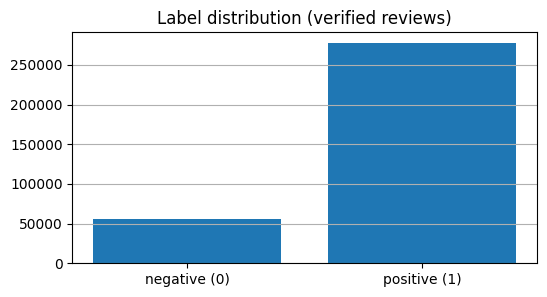

count    332504.000000
mean         61.859644
std         138.944472
min           1.000000
50%          22.000000
90%         145.000000
95%         253.000000
99%         670.000000
max        5501.000000
Name: reviewText, dtype: float64


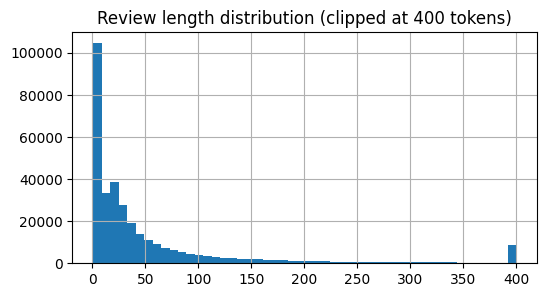

In [8]:
label_counts = verified_df["label"].value_counts().sort_index()
plt.figure(figsize=(6, 3))
plt.bar(["negative (0)", "positive (1)"], [label_counts.get(0, 0), label_counts.get(1, 0)])
plt.title("Label distribution (verified reviews)")
plt.grid(True, axis="y")
plt.show()

# Token count approximation via whitespace split (for EDA only)
lengths = verified_df["reviewText"].str.split().apply(len)
print(lengths.describe(percentiles=[0.5, 0.9, 0.95, 0.99]))

plt.figure(figsize=(6, 3))
plt.hist(lengths.clip(upper=400), bins=50)
plt.title("Review length distribution (clipped at 400 tokens)")
plt.grid(True)
plt.show()


## 5) Balanced train/validation/test split (chapter strategy)

The chapter builds **balanced validation and test sets**, then uses the remaining data for training.

Reasoning:
- validation and test metrics become easier to interpret because both classes are equally represented,
- training can remain imbalanced (which reflects real data), and we can later address that using class weights.


In [9]:
random_seed = SEED

def train_valid_test_split(inputs, labels, train_fraction=0.8):
    """Splits a dataset into training/validation/test, balancing valid and test."""
    neg_indices = pd.Series(labels.loc[(labels == 0)].index)
    pos_indices = pd.Series(labels.loc[(labels == 1)].index)

    n_valid = int(min([len(neg_indices), len(pos_indices)]) * ((1 - train_fraction) / 2.0))
    n_test = n_valid

    # Negative indices
    neg_test_inds = neg_indices.sample(n=n_test, random_state=random_seed)
    neg_valid_inds = neg_indices.loc[~neg_indices.isin(neg_test_inds)].sample(n=n_valid, random_state=random_seed)
    neg_train_inds = neg_indices.loc[~neg_indices.isin(neg_test_inds.tolist() + neg_valid_inds.tolist())]

    # Positive indices
    pos_test_inds = pos_indices.sample(n=n_test, random_state=random_seed)
    pos_valid_inds = pos_indices.loc[~pos_indices.isin(pos_test_inds)].sample(n=n_valid, random_state=random_seed)
    pos_train_inds = pos_indices.loc[~pos_indices.isin(pos_test_inds.tolist() + pos_valid_inds.tolist())]

    tr_x = inputs.loc[neg_train_inds.tolist() + pos_train_inds.tolist()].sample(frac=1.0, random_state=random_seed)
    tr_y = labels.loc[neg_train_inds.tolist() + pos_train_inds.tolist()].sample(frac=1.0, random_state=random_seed)

    v_x = inputs.loc[neg_valid_inds.tolist() + pos_valid_inds.tolist()].sample(frac=1.0, random_state=random_seed)
    v_y = labels.loc[neg_valid_inds.tolist() + pos_valid_inds.tolist()].sample(frac=1.0, random_state=random_seed)

    ts_x = inputs.loc[neg_test_inds.tolist() + pos_test_inds.tolist()].sample(frac=1.0, random_state=random_seed)
    ts_y = labels.loc[neg_test_inds.tolist() + pos_test_inds.tolist()].sample(frac=1.0, random_state=random_seed)

    print(f"Training data: {len(tr_x)}")
    print(f"Validation data: {len(v_x)} (balanced)")
    print(f"Test data: {len(ts_x)} (balanced)")

    return (tr_x, tr_y), (v_x, v_y), (ts_x, ts_y)

data = verified_df["reviewText"]
labels = verified_df["label"]

(tr_x, tr_y), (v_x, v_y), (ts_x, ts_y) = train_valid_test_split(data, labels, train_fraction=0.8)

print("Train label distribution:")
print(tr_y.value_counts())
print("Valid label distribution:")
print(v_y.value_counts())
print("Test label distribution:")
print(ts_y.value_counts())


Training data: 310388
Validation data: 11058 (balanced)
Test data: 11058 (balanced)
Train label distribution:
label
1    266155
0     44233
Name: count, dtype: int64
Valid label distribution:
label
0    5529
1    5529
Name: count, dtype: int64
Test label distribution:
label
0    5529
1    5529
Name: count, dtype: int64


## 6) Corpus analysis: vocabulary size and sequence length

This section follows the chapter’s idea: choose vocabulary size and sequence length based on training data statistics.

### 6.1 Vocabulary size
If vocabulary is too small, many informative words become OOV (“out of vocabulary”).  
If vocabulary is too large, training becomes heavier and can pick up noise.

I inspect the word frequency distribution and see how many tokens are covered by the top-*k* words.

### 6.2 Sequence length
Text length is variable. For a fixed-size model input, I need to pick a max sequence length.
Common practice is to cover most of the data (e.g., 90–95th percentile), and truncate extremely long reviews.


Unique tokens (approx): 104942
Most common tokens: [('the', 990324), ('and', 525609), ('to', 482744), ('a', 478473), ('i', 443694), ('it', 385254), ('is', 329780), ('of', 328369), ('game', 318444), ('this', 287769)]
Top-k for 90% coverage: 2246
Top-k for 95% coverage: 4986
Top-k for 99% coverage: 21769


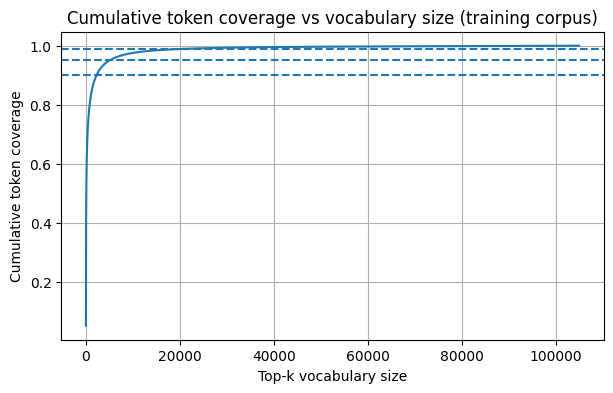

count    310388.000000
mean         61.260902
std         138.840233
min           0.000000
50%          22.000000
90%         143.000000
95%         251.000000
99%         669.130000
max        5626.000000
Name: reviewText, dtype: float64


In [10]:
# Tokenize training data with a simple whitespace split (EDA purpose)
tokenized = tr_x.str.lower().str.replace(r"[^a-z0-9\s']", " ", regex=True).str.split()

# Flatten all tokens
data_list = [w for doc in tokenized for w in doc if w]
counter = Counter(data_list)

print("Unique tokens (approx):", len(counter))
print("Most common tokens:", counter.most_common(10))

# Cumulative coverage curve
freqs = np.array([c for _, c in counter.most_common()])
cum = np.cumsum(freqs) / np.sum(freqs)

# Find coverage points
def coverage_k(target=0.9):
    return int(np.searchsorted(cum, target) + 1)

k90 = coverage_k(0.90)
k95 = coverage_k(0.95)
k99 = coverage_k(0.99)

print("Top-k for 90% coverage:", k90)
print("Top-k for 95% coverage:", k95)
print("Top-k for 99% coverage:", k99)

plt.figure(figsize=(7, 4))
plt.plot(cum)
plt.axhline(0.90, linestyle="--")
plt.axhline(0.95, linestyle="--")
plt.axhline(0.99, linestyle="--")
plt.title("Cumulative token coverage vs vocabulary size (training corpus)")
plt.xlabel("Top-k vocabulary size")
plt.ylabel("Cumulative token coverage")
plt.grid(True)
plt.show()

# Sequence length distribution (token count)
seq_lens = tokenized.apply(len)
print(seq_lens.describe(percentiles=[0.5, 0.9, 0.95, 0.99]))


## 7) End-to-end TensorFlow pipeline with `TextVectorization`

In this section, I build the actual modeling pipeline in TensorFlow:
- input: raw text (`tf.string`)
- `TextVectorization` layer: standardization + tokenization + mapping to token IDs
- `Embedding` layer: dense word vectors
- LSTM encoder
- classifier head

This design makes the model portable: the preprocessing is part of the model.


In [11]:
VOCAB_SIZE = 30_000
SEQ_LEN = 200
EMBED_DIM = 128

def custom_standardize(text):
    # Lowercase + remove HTML breaks + keep apostrophes for common contractions
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, "<br />", " ")
    text = tf.strings.regex_replace(text, "[^a-z0-9\s']", " ")
    text = tf.strings.regex_replace(text, "\s+", " ")
    return tf.strings.strip(text)

vectorizer = tf.keras.layers.TextVectorization(
    standardize=custom_standardize,
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LEN,
)

# Adapt on training text only
vectorizer.adapt(tf.data.Dataset.from_tensor_slices(tr_x.values).batch(1024))

vocab = vectorizer.get_vocabulary()
print("Vocabulary size learned:", len(vocab))
print("First 20 tokens:", vocab[:20])

# Quick vectorization sanity check
sample = tf.constant(["This game is amazing, I love it!", "Terrible controls and boring."])
print(vectorizer(sample)[:2])


<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-4188526510.py:9: SyntaxWarning: invalid escape sequence '\s'
  text = tf.strings.regex_replace(text, "[^a-z0-9\s']", " ")
/tmp/ipython-input-4188526510.py:10: SyntaxWarning: invalid escape sequence '\s'
  text = tf.strings.regex_replace(text, "\s+", " ")


Vocabulary size learned: 30000
First 20 tokens: ['', '[UNK]', np.str_('the'), np.str_('and'), np.str_('to'), np.str_('a'), np.str_('i'), np.str_('it'), np.str_('is'), np.str_('of'), np.str_('game'), np.str_('this'), np.str_('you'), np.str_('for'), np.str_('in'), np.str_('that'), np.str_('but'), np.str_('with'), np.str_('on'), np.str_('have')]
tf.Tensor(
[[ 11  10   8 209   6  63   7   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   

## 8) `tf.data` datasets for training

I build `tf.data.Dataset` objects for:
- training (shuffled, batched),
- validation,
- test.

Because training data is imbalanced, I also compute **class weights** so the loss penalizes minority class errors more.
This is optional, but it can stabilize training when the skew is strong.


In [12]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE

def make_ds(x, y, training):
    ds = tf.data.Dataset.from_tensor_slices((x.values, y.values))
    if training:
        ds = ds.shuffle(buffer_size=min(len(x), 50_000), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(tr_x, tr_y, training=True)
valid_ds = make_ds(v_x, v_y, training=False)
test_ds  = make_ds(ts_x, ts_y, training=False)

# Class weights (inverse frequency)
neg = int((tr_y == 0).sum())
pos = int((tr_y == 1).sum())
total = neg + pos

class_weight = {
    0: total / (2.0 * neg),
    1: total / (2.0 * pos),
}
print("Class weights:", class_weight)


Class weights: {0: 3.5085569597359436, 1: 0.5830963160564333}


## 9) Model: Embedding + (Bi)LSTM + classifier

This is the main model for the chapter. The flow is:
- vectorize text into token IDs,
- embed into dense vectors,
- LSTM reads the sequence and outputs a representation,
- dense head predicts sentiment probability.

I use:
- dropout to reduce overfitting,
- AUC and precision/recall as additional metrics (useful for imbalanced data).


In [13]:
from tensorflow.keras import layers

def build_lstm_sentiment_model(vectorizer):
    inp = layers.Input(shape=(1,), dtype=tf.string)
    x = vectorizer(inp)
    x = layers.Embedding(VOCAB_SIZE, EMBED_DIM, mask_zero=True)(x)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inp, out)
    return model

model = build_lstm_sentiment_model(vectorizer)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ],
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 200)       │          0 │ input_layer[0][0] │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 128)  │  3,840,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 200)       │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     98,816 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,947,137 (15.06 MB)

 Trainable params: 3,947,137 (15.06 MB)

 Non-trainable params: 0 (0.00 B)

## 10) Training

I use a few standard callbacks:
- EarlyStopping: stop when validation AUC stops improving,
- ModelCheckpoint: save best model weights.

You can increase epochs if you want to push performance further.


In [17]:
VOCAB_SIZE = 20000
MAX_LEN = 200

vectorize = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_LEN,  # key: produces dense right-padded sequences
)

vectorize.adapt(train_ds.map(lambda x, y: x))


In [18]:
AUTOTUNE = tf.data.AUTOTUNE

def to_tokens(x, y):
    x = vectorize(x)                  # (batch, MAX_LEN)
    y = tf.cast(y, tf.float32)        # for AUC / sigmoid output
    return x, y

train_tok = train_ds.map(to_tokens, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
valid_tok = valid_ds.map(to_tokens, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)


In [19]:
inputs = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int64)
x = tf.keras.layers.Embedding(VOCAB_SIZE, 128, mask_zero=True)(inputs)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.AUC(name="auc")]
)


In [20]:
history = model.fit(
    train_tok,
    validation_data=valid_tok,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weight,
    verbose=1,
)


Epoch 1/5
  10/2425 ━━━━━━━━━━━━━━━━━━━━ 1:13 30ms/step - auc: 0.5839 - loss: 0.7028

InvalidArgumentError: Graph execution error:

Detected at node functional_1_1/bidirectional_1_1/forward_lstm_1_1/Assert/Assert defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.12/dist-packages/tornado/platform/asyncio.py", line 211, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 645, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipython-input-503646258.py", line 1, in <cell line: 0>

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 377, in fit

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 133, in multi_step_on_iterator

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 114, in one_step_on_data

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 58, in train_step

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py", line 936, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/ops/operation.py", line 58, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py", line 183, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/ops/function.py", line 177, in _run_through_graph

  File "/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py", line 648, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py", line 936, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/ops/operation.py", line 58, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py", line 218, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py", line 936, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/ops/operation.py", line 58, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/lstm.py", line 583, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py", line 406, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/lstm.py", line 550, in inner_loop

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/rnn.py", line 841, in lstm

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/rnn.py", line 874, in _cudnn_lstm

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/rnn.py", line 557, in _assert_valid_mask

assertion failed: [You are passing a RNN mask that does not correspond to right-padded sequences, while using cuDNN, which is not supported. With cuDNN, RNN masks can only be used for right-padding, e.g. `[[True, True, False, False]]` would be a valid mask, but any mask that isn\'t just contiguous `True`\'s on the left and contiguous `False`\'s on the right would be invalid. You can pass `use_cudnn=False` to your RNN layer to stop using cuDNN (this may be slower).]
	 [[{{node functional_1_1/bidirectional_1_1/forward_lstm_1_1/Assert/Assert}}]] [Op:__inference_multi_step_on_iterator_123476]

In [16]:
x_batch, y_batch = next(iter(train_ds))

print("train_ds.element_spec:", train_ds.element_spec)
print("x type:", type(x_batch))

try:
    print("x shape:", x_batch.shape, "x dtype:", x_batch.dtype)
except Exception as e:
    print("Cannot read shape/dtype:", e)

# If it's strings, show a sample:
try:
    print("x sample:", x_batch[:2].numpy())
except Exception:
    pass


train_ds.element_spec: (TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))
x type: <class 'tensorflow.python.framework.ops.EagerTensor'>
x shape: (128,) x dtype: <dtype: 'string'>
x sample: [b'NOT MUCH TO SAY THEIR MADE OF METAL AND YOU LIFT THEM . WEIGHTS WERE ACCURATE TO LISTED WEIGHT. GOOD DEAL'
 b'My friend tells it is not work well.']


In [15]:
import numpy as np

x_batch, y_batch = next(iter(train_ds))
x_batch = x_batch.numpy()

def is_right_padded(seq):
    zero_pos = np.where(seq == 0)[0]
    if len(zero_pos) == 0:
        return True
    first_zero = zero_pos[0]
    return np.all(seq[first_zero:] == 0)

bad = [i for i, s in enumerate(x_batch) if not is_right_padded(s)]
print("Bad sequences:", len(bad))
if bad:
    i = bad[0]
    print("Example bad seq:", x_batch[i][:80])


Bad sequences: 0


/tmp/ipython-input-2778246051.py:7: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  zero_pos = np.where(seq == 0)[0]


In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

EPOCHS = 5
ckpt_path = "ch09_sentiment_best.keras"

callbacks = [
    ModelCheckpoint(ckpt_path, monitor="val_auc", mode="max", save_best_only=True),
    EarlyStopping(monitor="val_auc", mode="max", patience=2, restore_best_weights=True),
]

history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weight,  # can remove if you want pure baseline
    verbose=1,
)


Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node functional_1/bidirectional_1/forward_lstm_1/Assert/Assert defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.12/dist-packages/tornado/platform/asyncio.py", line 211, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 645, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipython-input-4181840065.py", line 11, in <cell line: 0>

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 377, in fit

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 133, in multi_step_on_iterator

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 114, in one_step_on_data

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 58, in train_step

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py", line 936, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/ops/operation.py", line 58, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py", line 183, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/ops/function.py", line 177, in _run_through_graph

  File "/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py", line 648, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py", line 936, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/ops/operation.py", line 58, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py", line 218, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py", line 936, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/ops/operation.py", line 58, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/lstm.py", line 583, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py", line 406, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/lstm.py", line 550, in inner_loop

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/rnn.py", line 841, in lstm

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/rnn.py", line 874, in _cudnn_lstm

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/rnn.py", line 557, in _assert_valid_mask

assertion failed: [You are passing a RNN mask that does not correspond to right-padded sequences, while using cuDNN, which is not supported. With cuDNN, RNN masks can only be used for right-padding, e.g. `[[True, True, False, False]]` would be a valid mask, but any mask that isn\'t just contiguous `True`\'s on the left and contiguous `False`\'s on the right would be invalid. You can pass `use_cudnn=False` to your RNN layer to stop using cuDNN (this may be slower).]
	 [[{{node functional_1/bidirectional_1/forward_lstm_1/Assert/Assert}}]] [Op:__inference_multi_step_on_iterator_18101]

### 10.1 Plot learning curves

In [ ]:
def plot_history(hist, keys):
    plt.figure(figsize=(10, 4))
    for k in keys:
        if k in hist.history:
            plt.plot(hist.history[k], label=k)
    plt.xlabel("Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(history, ["loss", "val_loss"])
plot_history(history, ["accuracy", "val_accuracy"])
plot_history(history, ["auc", "val_auc"])


## 11) Evaluation

I evaluate on the balanced test set and then compute:
- confusion matrix,
- a small classification report,
- and inspect examples (high-confidence predictions + mistakes).

This is a practical check that the model is not only scoring well but also behaving sensibly.


In [ ]:
test_metrics = model.evaluate(test_ds, verbose=1)
for name, value in zip(model.metrics_names, test_metrics):
    print(f"{name:12s}: {value:.4f}")


In [ ]:
# Collect predictions for analysis
y_true = []
y_prob = []
x_text = []

for batch_x, batch_y in test_ds:
    p = model.predict(batch_x, verbose=0).reshape(-1)
    y_prob.extend(p.tolist())
    y_true.extend(batch_y.numpy().tolist())
    x_text.extend(batch_x.numpy().astype(str).tolist())

y_true = np.array(y_true, dtype=int)
y_prob = np.array(y_prob, dtype=float)
y_pred = (y_prob >= 0.5).astype(int)

from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)
print()
print(classification_report(y_true, y_pred, digits=4))


### 11.1 Inspect extreme predictions

I inspect:
- the most confident positive predictions,
- the most confident negative predictions.

This is a quick quality check and often reveals issues like:
- the model rewarding generic positive language,
- or overreacting to strong negative keywords.


In [ ]:
def show_examples(title, indices, n=5):
    print("\n" + title)
    print("-" * len(title))
    for i in indices[:n]:
        print(f"prob={y_prob[i]:.4f}  true={y_true[i]}  pred={y_pred[i]}")
        print(x_text[i][:400].replace("\n", " "))
        print()

# Top positive and top negative
top_pos = np.argsort(-y_prob)
top_neg = np.argsort(y_prob)

show_examples("Most confident positives", top_pos, n=5)
show_examples("Most confident negatives", top_neg, n=5)


### 11.2 Inspect mistakes (false positives and false negatives)

This is the most useful debugging step:
- **false positive**: model says positive but true label is negative,
- **false negative**: model says negative but true label is positive.

Reading these examples helps identify patterns such as:
- negations (“not good”, “doesn’t work”),
- sarcasm,
- rare domain-specific terms,
- or mislabeled/ambiguous reviews.


In [ ]:
false_pos = np.where((y_true == 0) & (y_pred == 1))[0]
false_neg = np.where((y_true == 1) & (y_pred == 0))[0]

# Sort mistakes by confidence (how wrong the model is)
fp_sorted = false_pos[np.argsort(-y_prob[false_pos])]
fn_sorted = false_neg[np.argsort(y_prob[false_neg])]  # low prob but true positive

show_examples("False positives (most confident mistakes)", fp_sorted, n=5)
show_examples("False negatives (most confident mistakes)", fn_sorted, n=5)


## 12) Inspecting the learned word vectors (Embedding layer)

The embedding layer learns a vector for each token.  
A simple way to check whether embeddings carry useful information is to look at nearest neighbors in embedding space:
- pick a token,
- compute cosine similarity between its vector and other token vectors,
- list the most similar tokens.

This is not a “proof” that embeddings are good, but it is a practical sanity check.


In [ ]:
# Extract embedding matrix and vocabulary
embedding_layer = None
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Embedding):
        embedding_layer = layer
        break

emb = embedding_layer.get_weights()[0]  # (vocab_size, embed_dim)
vocab = vectorizer.get_vocabulary()

# Build token -> id mapping (skip special tokens)
token_to_id = {tok: i for i, tok in enumerate(vocab)}

def nearest_neighbors(token, k=10):
    if token not in token_to_id:
        print("Token not in vocabulary:", token)
        return

    idx = token_to_id[token]
    v = emb[idx]
    v = v / (np.linalg.norm(v) + 1e-8)

    E = emb / (np.linalg.norm(emb, axis=1, keepdims=True) + 1e-8)
    sims = E @ v

    # Exclude the token itself
    best = np.argsort(-sims)
    best = [i for i in best if i != idx][:k]

    print(f"Nearest neighbors for '{token}':")
    for i in best:
        print(f"  {vocab[i]:15s}  sim={sims[i]:.4f}")

nearest_neighbors("great", k=10)
nearest_neighbors("bad", k=10)


## 13) Takeaways

- Real-world text data is messy, and data filtering decisions (like `verified` purchases) can materially affect the training distribution.
- Problem formulation matters: mapping 5-class ratings to 2-class sentiment simplifies optimization and makes evaluation clearer.
- Balanced validation/test sets make metrics easier to trust, even if training remains imbalanced.
- Vocabulary size and sequence length are not arbitrary—they should be measured from the training corpus.
- Putting preprocessing in the model (`TextVectorization`) makes the pipeline reproducible and portable.
- Inspecting predictions (both correct and incorrect) is a practical step that prevents over-trusting a single metric.


## 14) References

- Thushan Ganegedara, *TensorFlow in Action* (Chapter 9).
- UCSD Amazon Review Data (small category files).
- TensorFlow / Keras: `TextVectorization`, `Embedding`, `LSTM`.
